In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree



import networkx as nx

from scipy.spatial import distance

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

# Load the data 

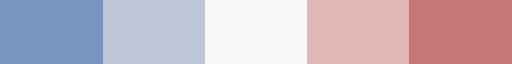

In [3]:
newcmp = list(sns.color_palette("vlag",5))
newcmp[2] = "#F9F9F9"
newcmp = ListedColormap(newcmp)   
newcmp

## scRNA

In [4]:
adata_sc = sc.read("../data/interim/cnv.h5ad")


In [5]:
clones_sc = adata_sc.obs["leiden"]

In [6]:
#change data type of clones_vis to int
clones_sc = clones_sc.astype(int)

In [7]:
clones = clones_sc.values

In [8]:
clones

array([16, 16, 10, ...,  2,  2,  3])

In [9]:
tmp_sc = adata_sc.X

In [10]:
cons_sc = []
sc_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == cl)[0]
    values = tmp_sc[idx,:]
    values = np.median(values, axis = 0)
    cons_sc.append(values)
    sc_clone_size[cl] = len(idx)
    

In [11]:
sc_clone_size

{0: 1567,
 1: 1320,
 2: 949,
 3: 938,
 4: 837,
 5: 817,
 6: 666,
 7: 615,
 8: 583,
 9: 517,
 10: 512,
 11: 376,
 12: 321,
 13: 314,
 14: 230,
 15: 70,
 16: 67,
 17: 22}

In [25]:
cons_sc = pd.DataFrame(cons_sc, columns = adata_sc.var.index)

In [31]:
chroms = pd.read_csv("../data/interim/FRP_copykat_CNA_results.txt", sep = "\t",usecols = ["chrom","abspos"] )

In [32]:
chroms = chroms.set_index("abspos")

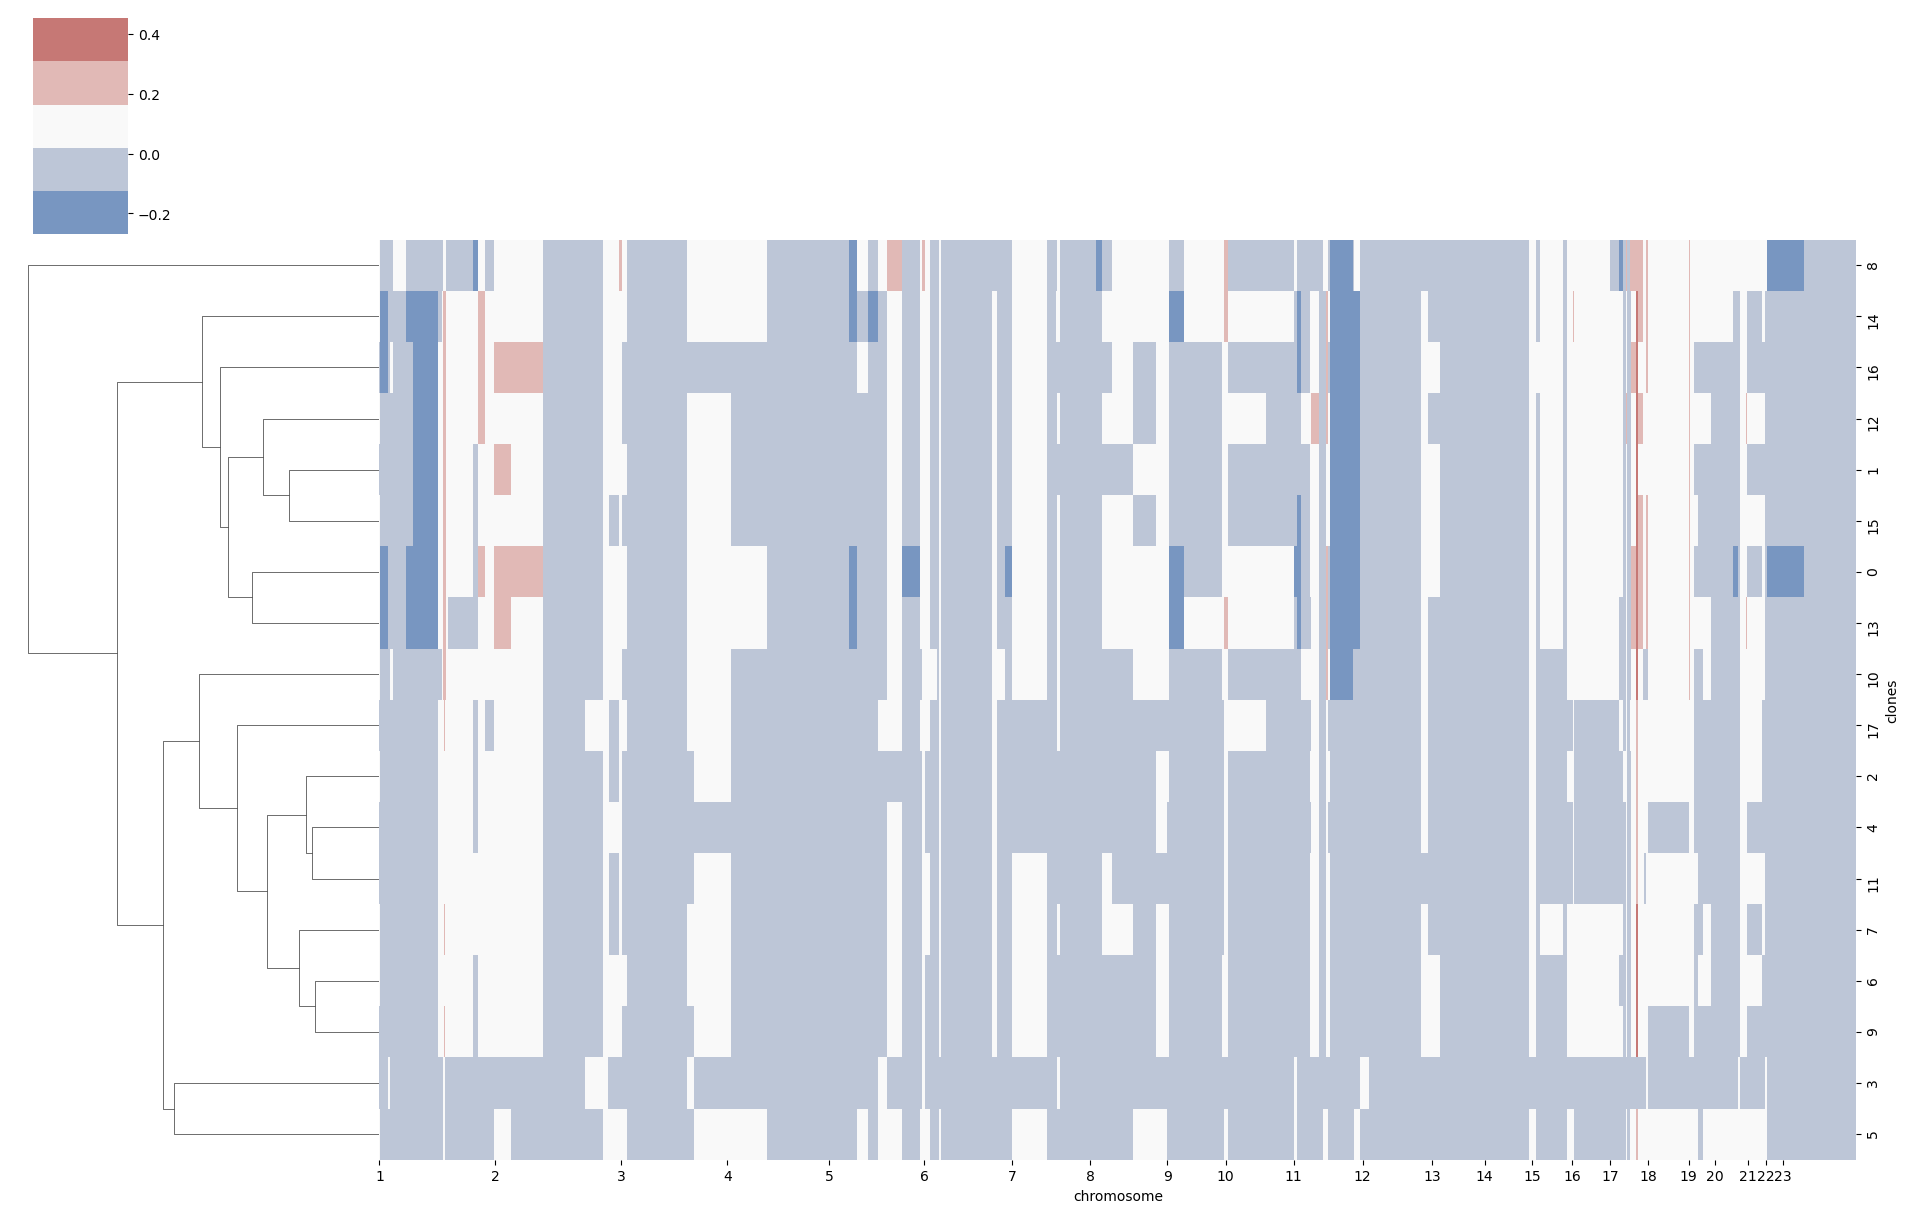

In [36]:

g = sns.clustermap(cons_sc, cmap = newcmp, figsize = (19,12), xticklabels = False,
                   col_cluster = False, row_cluster = True)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms.chrom

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




In [62]:
cons = cons_sc.T.copy()
diploid_id = cons.columns[-1]+1
cons[diploid_id] = 0
cons = cons.T
n_clusters = cons.shape[0]
X = np.zeros((n_clusters, n_clusters))
for c1 in range(n_clusters):
    cells1 = cons.loc[c1]
    for c2 in range(n_clusters):

        cells2 =  cons.loc[c2]
        dist = np.sqrt(np.sum(cells1-cells2)**2)
        X[c1,c2] = dist
        if c1 != c2 and dist ==0:
            dist = 1e-06
            X[c1,c2] = dist

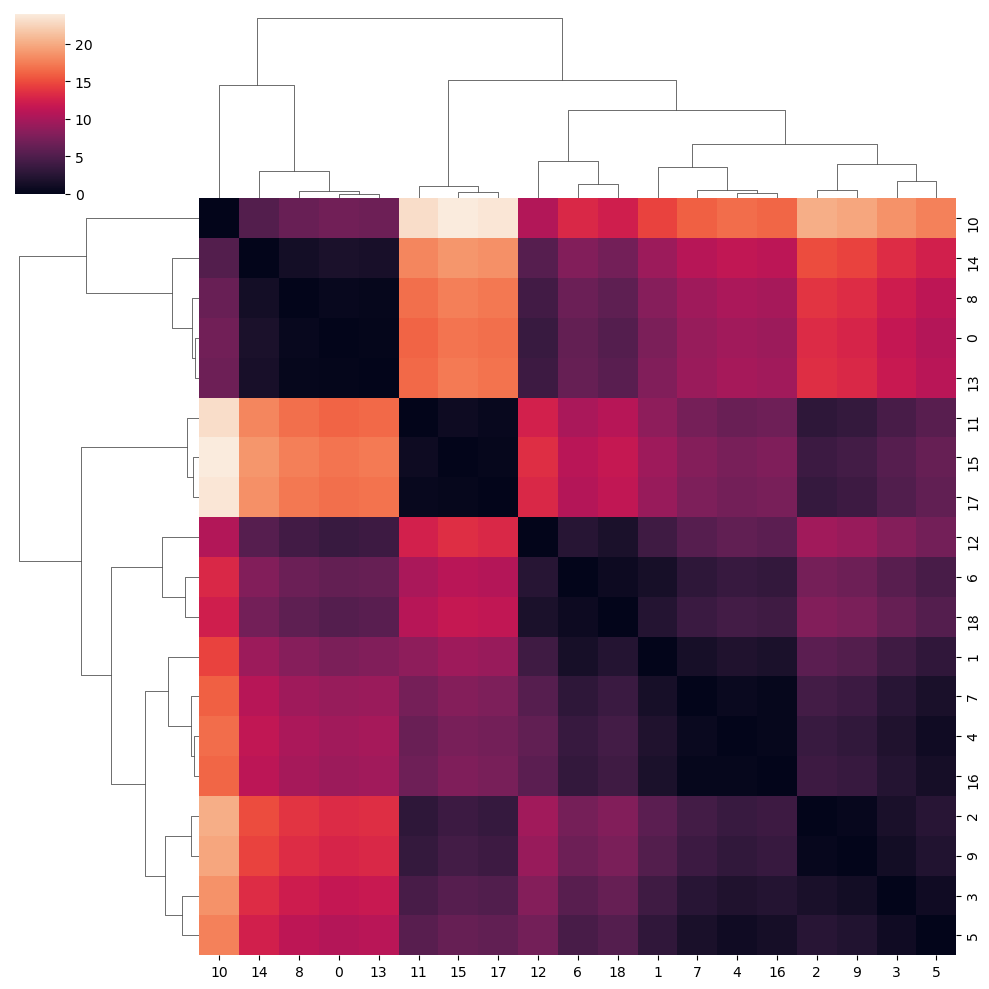

In [63]:
sns.clustermap(X)

In [171]:
X.shape

(19, 19)

In [85]:
np.save("../data/interim/clone_dist_over.npy",1-X/X.max())

In [86]:
adata_sc.obs["leiden"].to_csv("../data/interim/clones_over.csv")

In [92]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor,DistanceCalculator
from scipy.spatial import distance



In [ ]:
DistanceCalculator()

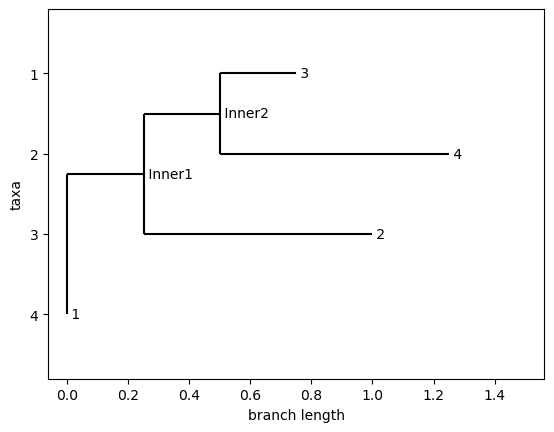

In [97]:
matrix = [[0, 1, 1, 1], [1, 0, 1, 2], [1, 1, 0, 1], [1, 2, 1, 0]]
dist_matrix = []
for i in range(len(matrix)):
    row = []
    for j in range(i + 1):  # Include only the lower triangle elements
        row.append(matrix[i][j])
    dist_matrix.append(row)

distance_matrix = DistanceMatrix(names=['1', '2', '3', '4'], matrix=dist_matrix)

# Perform hierarchical clustering
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)

# Set the root at node 0
tree.root_with_outgroup({'name': '1'})
tree.ladderize()  # Flip branches so deeper clades are displayed at top

# Draw the tree
Phylo.draw(tree)

In [127]:
len(matrix)

19

In [125]:
matrix = cons.values

In [136]:
dist_matrix = []

for i in range(len(matrix)):
    row = []
    for j in range(i + 1):  # Include only the lower triangle elements
        row.append(np.sum(abs(matrix[i,:] - matrix[j,:])))
    dist_matrix.append(row)



In [137]:

names = [str(x) for x in np.arange(cons.shape[0]-1)] + ["pseudo root"]
distance_matrix = DistanceMatrix(names=names, matrix=dist_matrix)

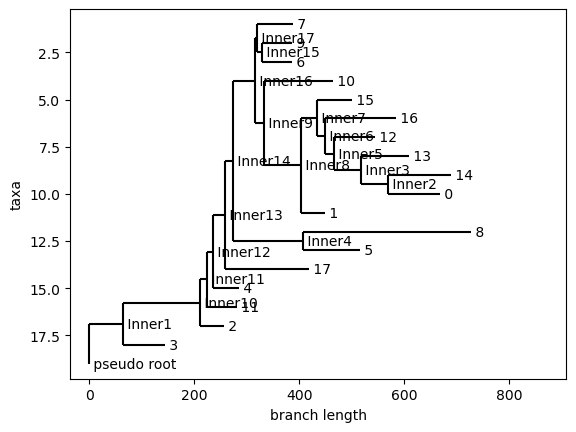

In [138]:
# Perform hierarchical clustering
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)

# Set the root at node 0
tree.root_with_outgroup({'name': 'pseudo root'})

# Draw the tree
Phylo.draw(tree)

<Figure size 1000x1000 with 0 Axes>

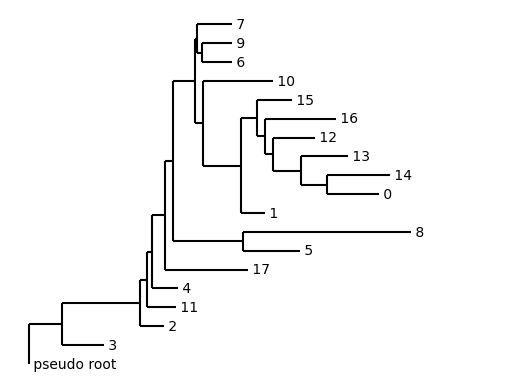

In [142]:
# Hide inner node labels
for clade in tree.find_clades():
    if not clade.is_terminal():
        clade.name = ''

# Draw the tree without inner node labels
plt.figure(figsize=(10, 10))
Phylo.draw(tree, do_show=False)
plt.axis('off')
plt.show()

In [172]:
# Initialize an empty matrix
num_taxa = len(tree.get_terminals())
dist_matrix = np.zeros((num_taxa, num_taxa))
new_names_row = []
new_names_cols = []
dist_np = np.zeros((num_taxa, num_taxa))
# Extract the pairwise distances from the tree
for i, leaf1 in enumerate(tree.get_terminals()):
    name1 = leaf1.name
    new_names_row.append(leaf1.name)
    for j, leaf2 in enumerate(tree.get_terminals()):
        name2 = leaf2.name
        if i != j:
            dist_matrix[i][j] = tree.distance(leaf1, leaf2)
            if name1 == "pseudo root":
                name1 = 18
            if name2 == "pseudo root":
                name2 = 18
            dist_np[int(name1),int(name2)] = dist_matrix[i][j]
            

In [173]:
np.save("../data/interim/clone_dist_over.npy",1-dist_np/dist_np.max())

In [174]:
dist_np

array([[  0.        , 310.01678346, 502.18760502, 683.31777941,
        481.64767946, 635.37440167, 421.87087977, 422.93776863,
        846.2500363 , 422.26938491, 467.1564105 , 497.74507832,
        281.63438372, 239.08478556, 219.11815536, 299.60023643,
        352.63284073, 566.78183545, 667.09742822],
       [310.01678346,   0.        , 283.76500352, 464.89517791,
        263.22507796, 416.95180017, 203.44827827, 204.51516713,
        627.8274348 , 203.84678341, 248.733809  , 279.32247682,
        187.90161283, 251.32009316, 330.86966042, 144.03450518,
        227.53506821, 348.35923395, 448.67482672],
       [502.18760502, 283.76500352,   0.        , 272.96736854,
        119.54621127, 350.96008511, 221.18741184, 222.2543007 ,
        561.83571974, 221.58591698, 299.03668344, 115.78487067,
        380.07243439, 443.49091471, 523.04048198, 336.20532674,
        419.70588977, 252.68813082, 256.74701736],
       [683.31777941, 464.89517791, 272.96736854,   0.        ,
        300.676

In [175]:
tree_dist = pd.DataFrame(dist_matrix, index = new_names_row, columns = new_names_row)

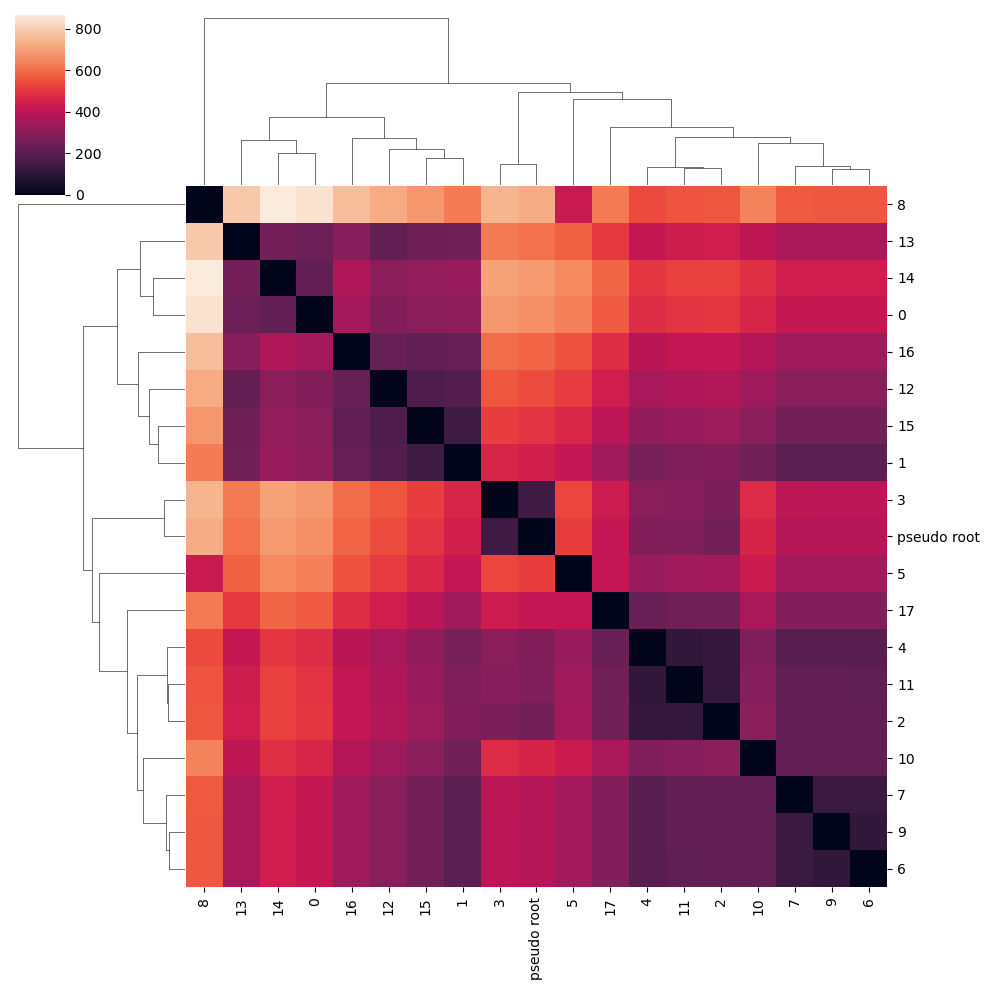

In [176]:
sns.clustermap(tree_dist)

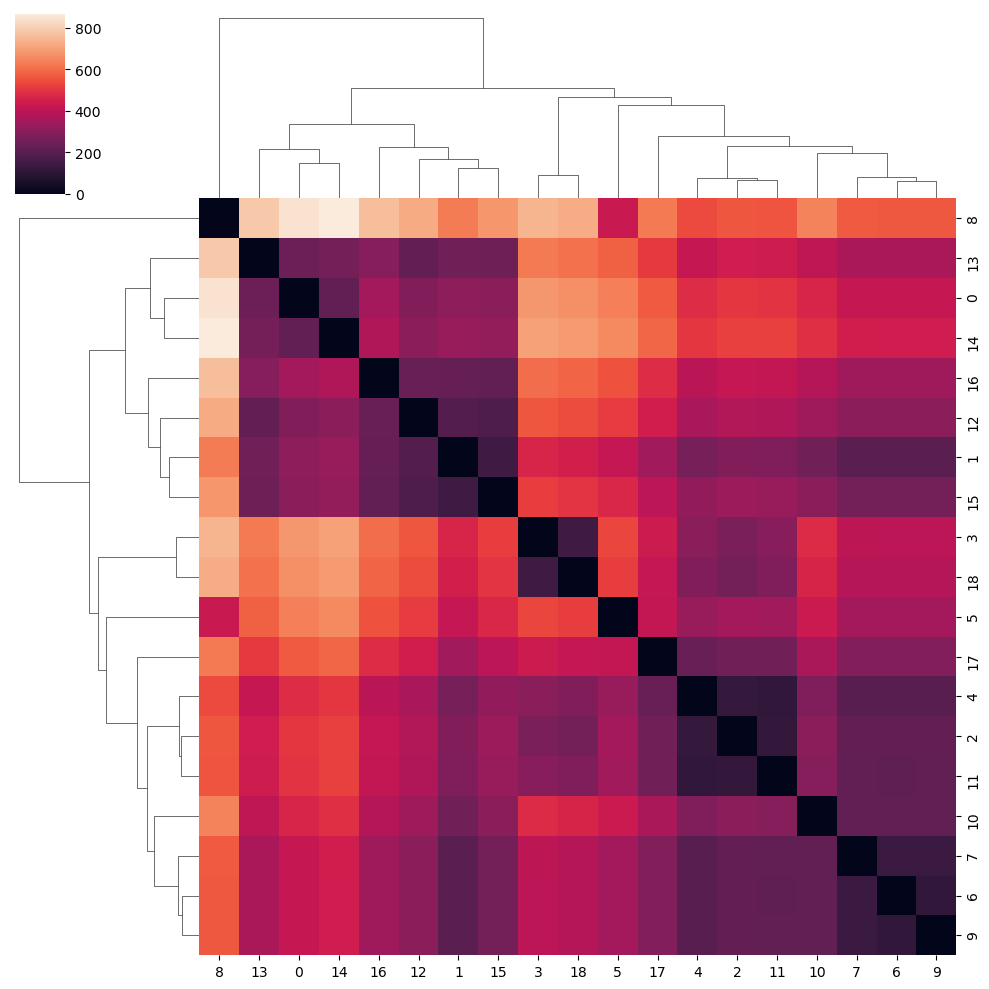

In [177]:
sns.clustermap(dist_np)

In [155]:
tree_dist.shape

(19, 19)

In [156]:
tree_dist.columns

Index(['7', '9', '6', '10', '15', '16', '12', '13', '14', '0', '1', '8', '5',
       '17', '4', '11', '2', '3', 'pseudo root'],
      dtype='object')